In [19]:
import pandas as pd
import numpy as np

In [2]:
def aggregate(df_path, main_question_col, desc_question_col, answer_col, link_col, link_href_col):
    df = pd.read_excel(df_path)
    df[main_question_col] = df[[
        main_question_col, link_col]
        ].bfill(axis=1).iloc[:,0]
    df_agg = df.fillna('NA').groupby(link_href_col).agg({
        main_question_col: lambda x: x.tolist()[0],
        desc_question_col: lambda x: x.tolist()[0],
        answer_col: lambda x: x.tolist(),
        }).reset_index()
    return df_agg.rename(columns={
        link_href_col: 'link',
        main_question_col: 'main_question',
        desc_question_col: 'desc_question',
        answer_col: 'answers'
        })

def preprocess(df_agg):
    list_out = []
    for line in df_agg.to_dict('records'):
        article_link_href = line['link']
        main_question_text = line['main_question']
        desc_question_text = line['desc_question']
        answer_text = line['answers']
        if 'Trả lời:' not in answer_text:
            continue
        else:
            is_answer = False
            desc_question_list_out = []
            answer_list_out = []
            for p in [desc_question_text] + answer_text:
                if p == 'Trả lời:':
                    is_answer = True
                elif not is_answer:
                    desc_question_list_out.append(p)
                else:
                    answer_list_out.append(p)
            if ')' in desc_question_list_out[-1][-5:]:
                desc_question_list_out[-1] = '('.join(desc_question_list_out[-1].split('(')[:-1])
            desc_question_text_out = '\n'.join(desc_question_list_out).strip()
            if len(answer_list_out) == 0:
                continue
            else:
                if answer_list_out[-1]=='NA' or 'tại đây' in answer_list_out[-1].lower() or 'độc giả' in answer_list_out[-1].lower():
                    answer_list_out.pop()
                if len(answer_list_out) == 0:
                    continue
                else:
                    source = answer_list_out[-1]
            answer_text_out = '\n'.join(answer_list_out[:-1])
            list_out.append([article_link_href, main_question_text, desc_question_text_out, answer_text_out, source])
    
    df_out = pd.DataFrame(list_out, columns=['link', 'main_question', 'desc_question', 'answers', 'source'])

    return df_out


In [3]:
df_clean = preprocess(aggregate(
    'data/health_v0.xlsx',
    'main-question-text',
    'desc-question-text',
    'answer-text',
    'article-link',
    'article-link-href'))
print(df_clean.shape)

(339, 5)


In [4]:
df_clean_v2 = preprocess(aggregate(
    'data/health_v1.xlsx',
    'main_question',
    'desc_question',
    'answers',
    'article-links',
    'article-links-href'))
print(df_clean_v2.shape)

(339, 5)


In [5]:
df_clean_v3 = preprocess(aggregate(
    'data/health-nutrition.xlsx',
    'main_question',
    'desc_question',
    'answers',
    'article-links',
    'article-links-href'))
print(df_clean_v3.shape)

(45, 5)


In [6]:
df_clean_v4 = preprocess(aggregate(
    'data/health-disease.xlsx',
    'main_question',
    'desc_question',
    'answers',
    'article-links',
    'article-links-href'))
print(df_clean_v4.shape)

(416, 5)


In [10]:
# Combine the dataframes and remove duplicates
df_clean_final = pd.concat([df_clean, df_clean_v2, df_clean_v3, df_clean_v4]).drop_duplicates(subset=['link']).reset_index(drop=True)

In [11]:
df_clean_final.drop(columns=['link'], inplace=True)
df_clean_final.head()

,main_question,desc_question,answers,source
0,Ăn bánh mì chấm sữa buổi sáng có tốt?,Gia đình tôi thường xuyên ăn bánh mì chấm sữa ...,Bánh mì chấm sữa buổi sáng được nhiều người lự...,"Tiến sĩ, bác sĩ Nguyễn Trọng Hưng\nViện Dinh d..."
1,Ăn bao nhiêu miếng bánh chưng thì không béo?,"Tôi rất thích ăn đồ nếp, đặc biệt là bánh chưn...",Bánh chưng là món ăn có lịch sử lâu đời và gắn...,Viện trưởng Viện Y học Ứng dụng Việt Nam
2,Ăn cá bụng to hay bé tốt hơn?,"Khi mua cá, tôi thường chọn những con bụng to ...",Mỗi loại cá có thành phần dinh dưỡng khác nhau...,PGS.TS Nguyễn Duy Thịnh\nViện Công nghệ sinh h...
3,Ăn cá hay thịt tốt hơn?,Nhiều người cho rằng nên ăn nhiều cá thay vì t...,Cá và thịt đều là nguồn protein chính và quan ...,PGS. TS Nguyễn Duy Thịnh\nViện Khoa học và Côn...
4,Ăn cà muối xổi có gây độc?,"Gia đình tôi hay ăn cà muối xổi, song nhiều th...","Cà pháo có tác dụng kích thích đường ruột, dễ ...",PGS Nguyễn Duy Thịnh\nViện Công nghệ sinh học ...


<AxesSubplot: >

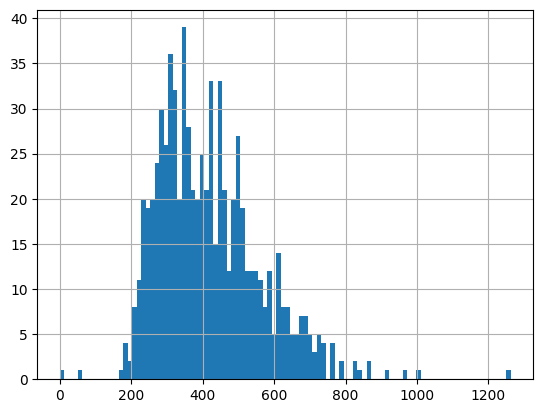

In [12]:
df_clean_final['num_words'] = df_clean_final['answers'].apply(lambda x: len(x.split()))
df_clean_final['num_words'].hist(bins=100)

In [13]:
df_clean_final[df_clean_final['num_words'].between(100,800)].reset_index(drop=True).to_parquet('data/clean/health_qa.parquet')

<AxesSubplot: >

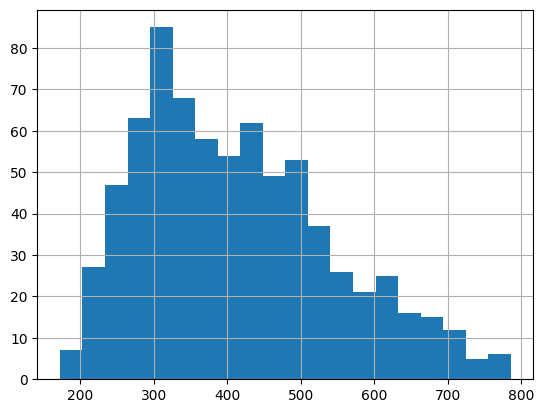

In [14]:
df_clean = pd.read_parquet('data/clean/health_qa.parquet')
df_clean.num_words.hist(bins=20)

In [17]:
print(df_clean[df_clean['num_words'].between(700,800)].iloc[20,2])

Trà sữa hiện là thức uống khoái khẩu không chỉ của trẻ em, thanh thiếu niên mà cả người lớn. Tuy có nhiều công thức nhưng cơ bản thức uống này gồm có nước, trà đen, sữa bột, kem sữa, đường, đá, hạt trân châu làm từ bột năng hay bột sắn, ca cao...
Đây là một thức uống vừa béo vừa ngọt, có đá nên mát giúp vừa giảm đói vừa giảm khát, thường được làm thành những ly lớn 500-750 ml. Trung bình, một ly trà sữa 500 ml chứa khoảng 300 kcalo. Các ly lớn hơn có thể cung cấp đến 500 kcalo - khoảng 1/3 nhu cầu của một đứa trẻ và 1/4 nhu cầu của người lớn trong một ngày.
Trà sữa trân châu cũng có thể được thêm nhiều đường. Báo cáo từ Food Science & Nutrition ước tính, mỗi cốc trà sữa 500 ml chứa khoảng 38g đường. Hàm lượng đường này sẽ thay đổi tùy theo hương vị và chất phụ gia được thêm vào cốc trà sữa. Chính điều này khiến đồ uống này trở thành thức uống đáng lo ngại với trẻ nhỏ và người lớn.
Học viện Nhi khoa Mỹ (AAP) khuyến nghị, trẻ em từ 2 tuổi trở lên bổ sung ít hơn 25 g đường mỗi ngày, trẻ e

In [20]:
# Train-test split 5% test
df_clean = pd.read_parquet('data/clean/health_qa.parquet')
np.random.seed(42)
df_clean['is_train'] = np.random.uniform(0, 1, len(df_clean)) <= .95
df_clean['is_train'].value_counts()


True     695
False     41
Name: is_train, dtype: int64